In [1]:
import cv2
import os
import requests
import numpy as np
import math
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set directory of cover images
cover_dirname = "C:/Users/PC/Masters Files/SteganographyDetection/Datasets/Dataset Cover Images"
# Set working directory
dirname = "C:/Users/PC/Masters Files/SteganographyDetection/Datasets/Dataset DCT"

In [3]:
# Generate Lorem Ipsum text
def random_message():
    response = requests.get("http://loripsum.net/api/1/headers/plaintext")
    if response.status_code == 200:
        secret_msg = response.text
    else:
        # Default secret message, when requests fail
        secret_msg = "Hello There!"
    secret_msg = secret_msg[:15]
    return secret_msg

In [4]:
quant = np.array([[16,11,10,16,24,40,51,61],
                  [12,12,14,19,26,58,60,55],
                  [14,13,16,24,40,57,69,56],
                  [14,17,22,29,51,87,80,62],
                  [18,22,37,56,68,109,103,77],
                  [24,35,55,64,81,104,113,92],
                  [49,64,78,87,103,121,120,101],
                  [72,92,95,98,112,100,103,99]])

In [5]:
message = None
bitMess = None
oriCol = 0
oriRow = 0
numBits = 0

In [6]:
def toBits(message):
    bits = []
    for char in message:
        binval = bin(ord(char))[2:].rjust(8,'0')
        bits.append(binval)
    numBits = bin(len(bits))[2:].rjust(8,'0')
    return bits

In [7]:
def addPadd(img, row, col):
    img = cv2.resize(img,(col+(8-col%8),row+(8-row%8)))    
    return img

In [8]:
"""Helper function to 'stitch' new image back together"""
def chunks(l, n):
    m = int(n)
    for i in range(0, len(l), m):
        yield l[i:i + m]

In [9]:
#encoding part
def encode_image(img,secret_msg):
    secret=secret_msg
    message = str(len(secret))+'*'+secret
    bitMess = toBits(message)
    #get size of image in pixels
    row,col = img.shape[:2]
    ##col, row = img.size
    oriRow, oriCol = row, col  
    if((col/8)*(row/8)<len(secret)):
        print("Error: Message too large to encode in image")
        return False
    #make divisible by 8x8
    if row%8 != 0 or col%8 != 0:
        img = addPadd(img, row, col)
        
    row,col = img.shape[:2]
    ##col, row = img.size
    #split image into RGB channels
    bImg,gImg,rImg = cv2.split(img)
    #message to be hid in blue channel so converted to type float32 for dct function
    bImg = np.float32(bImg)
    #break into 8x8 blocks
    imgBlocks = [np.round(bImg[j:j+8, i:i+8]-128) for (j,i) in itertools.product(range(0,row,8),
                                                                       range(0,col,8))]
    #Blocks are run through DCT function
    dctBlocks = [np.round(cv2.dct(img_Block)) for img_Block in imgBlocks]
    #blocks then run through quantization table
    quantizedDCT = [np.round(dct_Block/quant) for dct_Block in dctBlocks]
    #set LSB in DC value corresponding bit of message
    messIndex = 0
    letterIndex = 0
    for quantizedBlock in quantizedDCT:
        #find LSB in DC coeff and replace with message bit
        DC = quantizedBlock[0][0]
        DC = np.uint8(DC)
        DC = np.unpackbits(DC)
        DC[7] = bitMess[messIndex][letterIndex]
        DC = np.packbits(DC)
        DC = np.float32(DC)
        DC= DC-255
        quantizedBlock[0][0] = DC
        letterIndex = letterIndex+1
        if letterIndex == 8:
            letterIndex = 0
            messIndex = messIndex + 1
            if messIndex == len(message):
                break
    #blocks run inversely through quantization table
    sImgBlocks = [quantizedBlock *quant+128 for quantizedBlock in quantizedDCT]
    #blocks run through inverse DCT
    #sImgBlocks = [cv2.idct(B)+128 for B in quantizedDCT]
    #puts the new image back together
    sImg=[]
    for chunkRowBlocks in chunks(sImgBlocks, col/8):
        for rowBlockNum in range(8):
            for block in chunkRowBlocks:
                sImg.extend(block[rowBlockNum])
    sImg = np.array(sImg).reshape(row, col)
    #converted from type float32
    sImg = np.uint8(sImg)
    #show(sImg)
    sImg = cv2.merge((sImg,gImg,rImg))
    return sImg

In [10]:
#decoding part :
def decode_image(img):
    row,col = img.shape[:2]
    messSize = None
    messageBits = []
    buff = 0
    #split image into RGB channels
    bImg,gImg,rImg = cv2.split(img)
    #message hid in blue channel so converted to type float32 for dct function
    bImg = np.float32(bImg)
    #break into 8x8 blocks
    imgBlocks = [bImg[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),
                                                                    range(0,col,8))]    
    #blocks run through quantization table
    #quantizedDCT = [dct_Block/ (quant) for dct_Block in dctBlocks]
    quantizedDCT = [img_Block/quant for img_Block in imgBlocks]
    i=0
    #message extracted from LSB of DC coeff
    for quantizedBlock in quantizedDCT:
        DC = quantizedBlock[0][0]
        DC = np.uint8(DC)
        DC = np.unpackbits(DC)
        if DC[7] == 1:
            buff+=(0 & 1) << (7-i)
        elif DC[7] == 0:
            buff+=(1&1) << (7-i)
        i=1+i
        if i == 8:
            messageBits.append(chr(buff))
            buff = 0
            i =0
            if messageBits[-1] == '*' and messSize is None:
                try:
                    messSize = int(''.join(messageBits[:-1]))
                except:
                    pass
        if len(messageBits) - len(str(messSize)) - 1 == messSize:
            return ''.join(messageBits)[len(str(messSize))+1:]
    return ''

In [11]:
# Add stego payload
for i, filename in enumerate(os.listdir(cover_dirname)):
    cover_image = cv2.imread(cover_dirname + "/" + filename, cv2.IMREAD_UNCHANGED)
    secret_message = random_message()
    encoded_image = encode_image(cover_image, secret_message)
    cv2.imwrite(dirname + "/DCT" + filename, encoded_image)

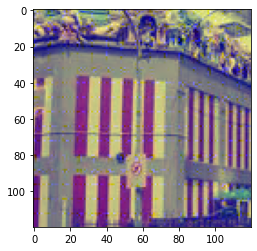

In [12]:
# Display the stego image
test_image = cv2.cvtColor(cv2.imread(dirname + "/DCT0.png"), cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()

In [13]:
stego_image = cv2.imread(dirname + "/DCT0.png", cv2.IMREAD_UNCHANGED)

In [14]:
stego_image.shape

(120, 120, 3)

In [15]:
# Attempt to decode the secret message
decoded_message = decode_image(stego_image)

In [16]:
print(decoded_message)

Quo studio Aris
